In [136]:
import sys
import praw


def redditClient():
    """
        Setup Reedit API authentication.
        Replace username, secrets and passwords with your own.

        @returns: praw Reddit object
    """

    try:
        clientId = "ce9nTY5WrcqfRykfhU_A0g"
        clientSecret = "3gdQaB_kRMKYIHxBK6xZODj4-0HlsA"
        password = "Suk.sas.97."
        userName = "MaskdManhunter10"
        userAgents = 'client for A2'

        redditClient = praw.Reddit(client_id = clientId,
                                   client_secret = clientSecret,
                                   password = password,
                                   username = userName,
                                   user_agent = userAgents)
    except KeyError:
        sys.stderr.write("Key or secret token are invalid.\n")
        sys.exit(1)


    return redditClient


In [143]:
from datetime import datetime
import json

def collect_data_for_year(subreddit, year, search_term):
    posts_data = []

    # Iterate through each month of the specified year
    for month in range(1, 13):
        start_date = datetime(year, month, 1)
        end_date = datetime(year, month + 1, 1) if month < 12 else datetime(year + 1, 1, 1)
        
        # Convert dates to Unix timestamps
        start_timestamp = int(start_date.timestamp())
        end_timestamp = int(end_date.timestamp())
        
        # Fetch posts for the entire month
        posts = subreddit.search(query=search_term, time_filter='all', limit=200)
        filtered_posts = [
            post for post in posts if start_timestamp <= post.created_utc < end_timestamp
        ]
        
        # Fetch data for each filtered post
        for post in filtered_posts:
            post_data = {
                "Year": year,
                "Month": month,
                "Title": post.title,
                "Creation Time": convert_unix_timestamp_to_datetime(post.created_utc),
                "Score": post.score,  # Score represents the overall score (upvotes - downvotes)
                "Number of Comments": post.num_comments,
                "Comments": [],
            }

            # Fetch up to 100 top-level comments for the current post
            for comment in post.comments:
                if len(post_data["Comments"]) >= 200:
                    break
                if isinstance(comment, praw.models.Comment):
                    comment_data = {
                        "Comment Body": comment.body,
                        "Comment Time": convert_unix_timestamp_to_datetime(comment.created_utc),
                        "Replies": len(comment.replies) if hasattr(comment, "replies") else 0,
                    }
                    post_data["Comments"].append(comment_data)

            posts_data.append(post_data)

    return posts_data

# Define a function to convert Unix timestamps to datetime
def convert_unix_timestamp_to_datetime(unix_timestamp):
    return datetime.utcfromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')

# Initialize the Reddit client
client = redditClient()

# Specify the subreddit, search term, start year, and end year
subreddit = client.subreddit("all")  
search_term = "Cristiano Ronaldo" 
start_year = 2006
end_year = 2023

# Create an empty list to store the collected data
data = []

# Loop through each year within the specified range
for year in range(start_year, end_year+1):
    print(f"Collecting data for {year}...")
    
    # Collect data for the current year
    year_data = collect_data_for_year(subreddit, year, search_term)
    
    # Extend the data list with the collected data for this year
    data.extend(year_data)

# Convert the data to JSON format with indentation for readability
json_data = json.dumps(data, indent=4)

# Specify the JSON file name
json_filename = 'data.json'

# Write the JSON data to the specified file
with open(json_filename, 'w', encoding='utf-8') as json_file:
    json_file.write(json_data)



In [145]:
import csv

def save_data_to_csv(data, csv_filename):
    # Define the CSV headers
    csv_headers = ["Year", "Month", "Title", "Creation Time", "Score", "Number of Comments", "Comment Body", "Comment Time", "Replies"]

    # Open the CSV file for writing
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csv_file:
        # Create a CSV writer object
        csv_writer = csv.DictWriter(csv_file, fieldnames=csv_headers)

        # Write the CSV header row
        csv_writer.writeheader()

        # Loop through each post's data in the provided data list
        for post_data in data:
            year = post_data["Year"]
            month = post_data["Month"]
            title = post_data["Title"]
            creation_time = post_data["Creation Time"]
            score = post_data.get("Score", "")  # Get the score attribute (if available)
            num_comments = post_data.get("Number of Comments", "")  # Get the number of comments attribute (if available)

            # Loop through each comment in the post's comments list
            for comment_data in post_data["Comments"]:
                comment_body = comment_data.get("Comment Body", "")
                comment_time = comment_data.get("Comment Time", "")
                replies = comment_data.get("Replies", "")  # Get the replies attribute (if available)

                # Write a row to the CSV file with the collected data
                csv_writer.writerow({
                    "Year": year,
                    "Month": month,
                    "Title": title,
                    "Creation Time": creation_time,
                    "Score": score,
                    "Number of Comments": num_comments,
                    "Comment Body": comment_body,
                    "Comment Time": comment_time,
                    "Replies": replies
                })


In [147]:
#Saving the data csv
csv_filename = 'data.csv'
save_data_to_csv(data, csv_filename)

In [157]:
# Loading our already saved csv file and checking the data distribution with respect to year
import pandas as pd


csv_filename = 'data.csv'  
df = pd.read_csv(csv_filename)

year_counts = df['Year'].value_counts().reset_index()

print(year_counts)

    Year  count
0   2022   5570
1   2023   4328
2   2021   4022
3   2020   1922
4   2018   1079
5   2016    706
6   2019    685
7   2017    646
8   2015    216
9   2013    198
10  2014     83


In [160]:
years_to_downsample = [2020,2021, 2022, 2023]

# Define the desired sample size for each year
desired_sample_size = 1500

# Create an empty DataFrame to store the downsampled data
downsampled_data = pd.DataFrame()

# Iterate through the years that need downsampling
for year in years_to_downsample:
    # Calculate the downsampling factor
    original_count = year_counts[year_counts['Year'] == year]['count'].values[0]
    downsampling_factor = min(1, desired_sample_size / original_count)
    
    # Randomly select a subset of data based on the downsampling factor
    sampled_data = df[df['Year'] == year].sample(frac=downsampling_factor, random_state=42)
    
    # Concatenate the sampled data with the downsampled_data DataFrame
    downsampled_data = pd.concat([downsampled_data, sampled_data])

# Combine the downsampled data with data for other years
final_data = pd.concat([df[df['Year'].isin(years_to_downsample) == False], downsampled_data])

# Save the final CSV file without the index
final_data.to_csv('downsampled_data.csv', index=False)



In [161]:
year_counts_final = final_data['Year'].value_counts().reset_index()
print(year_counts_final)

    Year  count
0   2020   1500
1   2021   1500
2   2022   1500
3   2023   1500
4   2018   1079
5   2016    706
6   2019    685
7   2017    646
8   2015    216
9   2013    198
10  2014     83


In [162]:
# Display the first few rows of the DataFrame
print(final_data.head())

# Check data types of columns
print(final_data.dtypes)


   Year  Month                                   Title        Creation Time   
0  2013     11  Cristiano Ronaldo hat-trick vs. Sweden  2013-11-19 21:27:43  \
1  2013     11  Cristiano Ronaldo hat-trick vs. Sweden  2013-11-19 21:27:43   
2  2013     11  Cristiano Ronaldo hat-trick vs. Sweden  2013-11-19 21:27:43   
3  2013     11  Cristiano Ronaldo hat-trick vs. Sweden  2013-11-19 21:27:43   
4  2013     11  Cristiano Ronaldo hat-trick vs. Sweden  2013-11-19 21:27:43   

   Score  Number of Comments   
0   2999                1235  \
1   2999                1235   
2   2999                1235   
3   2999                1235   
4   2999                1235   

                                        Comment Body         Comment Time   
0       All three assists were absolutely beautiful.  2013-11-19 21:31:09  \
1                                   Heartbreaking :(  2013-11-19 21:49:53   
2  The [celebration.](http://i.imgur.com/1zOEC9S....  2013-11-19 21:31:09   
3  Ronaldo will rightful

In [163]:
print(final_data.isnull().sum())

Year                  0
Month                 0
Title                 0
Creation Time         0
Score                 0
Number of Comments    0
Comment Body          0
Comment Time          0
Replies               0
dtype: int64


In [164]:
duplicates = final_data[final_data.duplicated(subset=['Comment Body'])]

# Display the duplicate rows based on 'Comment Body'
print(duplicates.count)

<bound method DataFrame.count of        Year  Month                                              Title   
64     2013     11             Cristiano Ronaldo hat-trick vs. Sweden  \
68     2013     11             Cristiano Ronaldo hat-trick vs. Sweden   
116    2013     12                             Cristiano Ronaldo jump   
118    2013     12                             Cristiano Ronaldo jump   
189    2013     12                             Cristiano Ronaldo jump   
...     ...    ...                                                ...   
15325  2023      1  Jorge Mendes stopped representing Cristiano Ro...   
16298  2023      3  Cristiano Ronaldo yellow card for simulation a...   
16001  2023      2  Damac 0 - [3] Al Nassr - Cristiano Ronaldo hat...   
16892  2023      4  Kun Agüero: «All of Cristiano Ronaldo's free-k...   
18322  2023      8  Raja Casablanca 0 - [1] Al-Nassr - Cristiano R...   

             Creation Time  Score  Number of Comments Comment Body   
64     2013-11-19 21

In [165]:
# Keep the first occurrence of each comment and remove subsequent duplicates
final_data = final_data.drop_duplicates(subset=['Comment Body'], keep='first')
duplicates = final_data[final_data.duplicated(subset=['Comment Body'])]

# Display the duplicate rows based on 'Comment Body'
print(duplicates.count)

<bound method DataFrame.count of Empty DataFrame
Columns: [Year, Month, Title, Creation Time, Score, Number of Comments, Comment Body, Comment Time, Replies]
Index: []>


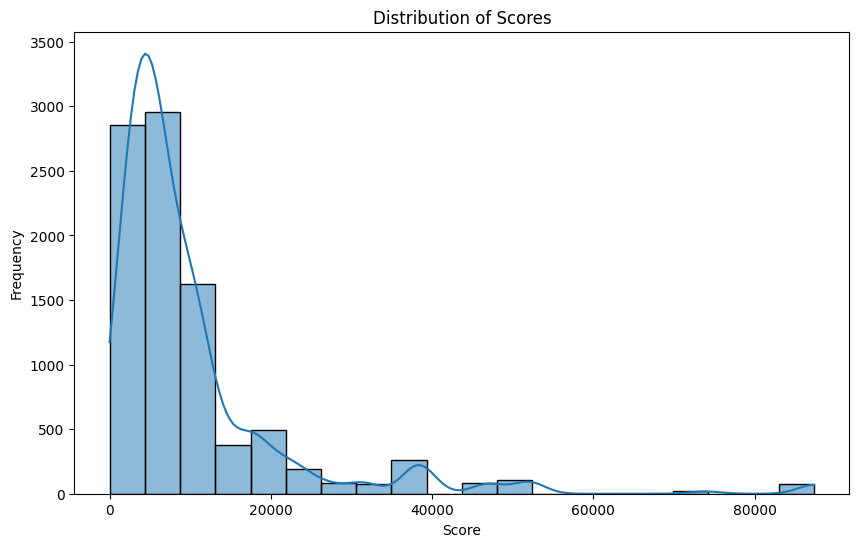

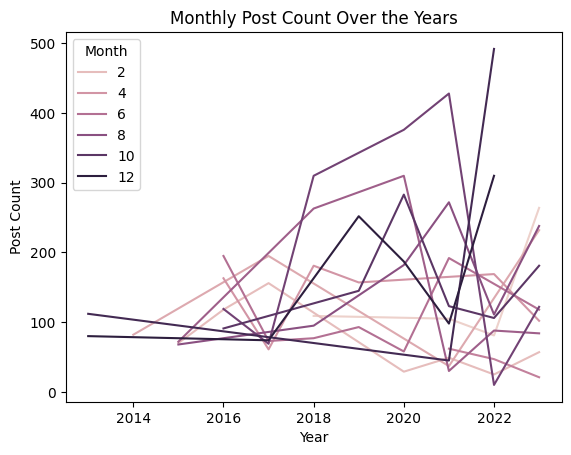

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Scores
plt.figure(figsize=(10, 6))
sns.histplot(final_data['Score'], bins=20, kde=True)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.show()

# Monthly Post Count
monthly_counts = final_data.groupby(['Year', 'Month']).size().reset_index(name='Post Count')
sns.lineplot(data=monthly_counts, x='Year', y='Post Count', hue='Month')
plt.xlabel('Year')
plt.ylabel('Post Count')
plt.title('Monthly Post Count Over the Years')
plt.show()


In [167]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re  
from bs4 import BeautifulSoup 

# Download NLTK resources 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define functions for text preprocessing
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Remove HTML entities
    text = re.sub(r'&\S+;', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word.isalnum() and word.lower() not in stopwords.words('english')]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply text preprocessing to your text columns in final_data
final_data['Title'] = final_data['Title'].apply(preprocess_text)
final_data['Comment Body'] = final_data['Comment Body'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sastr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sastr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sastr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\sastr\AppData\Local\Temp\ipykernel_63364\1490121253.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [168]:
# Combine all words from all comments and title into their individual lists
all_words_comments = ' '.join(final_data['Comment Body']).split()
final_data_grouped = final_data.groupby('Title').first().reset_index()
all_words_title = ' '.join(final_data_grouped['Comment Body']).split()

In [169]:
from collections import Counter
# Count the frequency of each word for both comments and title
word_count_comments = Counter(all_words_comments)
word_count_title = Counter(all_words_title)

In [170]:
# Get the top 10 most common words
top_10_words_comments = word_count_comments.most_common(10)
top_10_words_title = word_count_title.most_common(10)

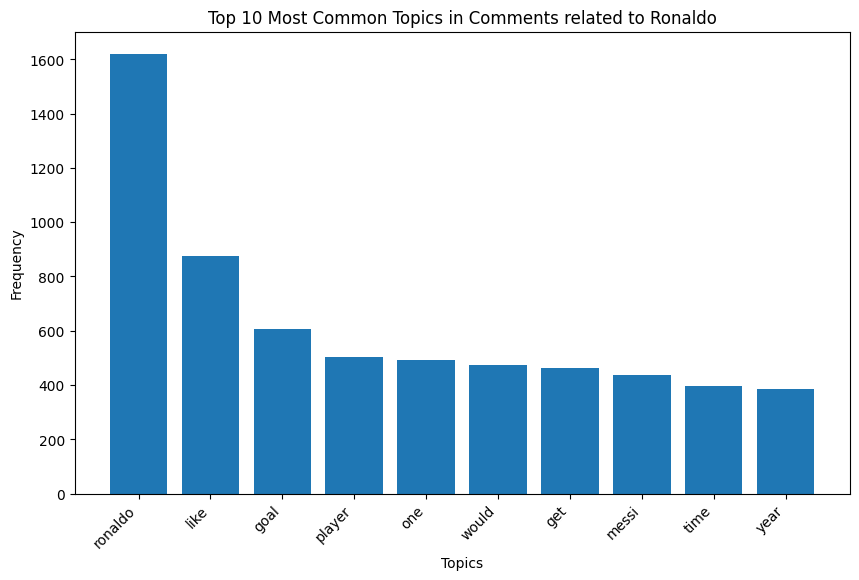

In [171]:
# Extract words and frequencies for the bar chart
words, frequencies = zip(*top_10_words_comments)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Topics in Comments related to Ronaldo')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.gca().set_facecolor('white')  # Set the background color to white
plt.grid(False)  # Remove grid lines
plt.show()

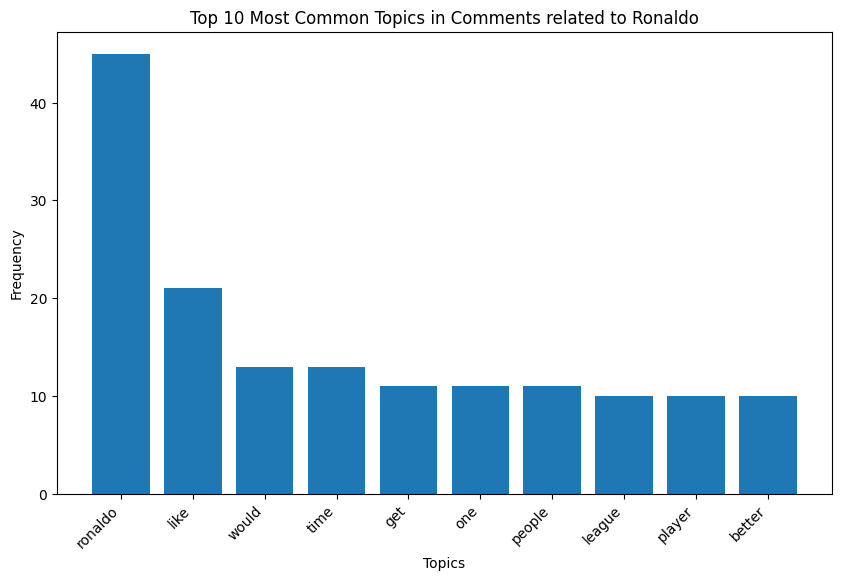

In [172]:
# Extract words and frequencies for the bar chart
words, frequencies = zip(*top_10_words_title)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Topics in Comments related to Ronaldo')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.gca().set_facecolor('white')  # Set the background color to white
plt.grid(False)  # Remove grid lines
plt.show()

In [173]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Convert tokens back to text
title_text = ' '.join(all_words_title)
comment_text = ' '.join(all_words_comments)

# Create a SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment for the title
title_sentiment_scores = analyzer.polarity_scores(title_text)

# Analyze sentiment for the comment
comment_sentiment_scores = analyzer.polarity_scores(comment_text)

# Determine sentiment labels for the title and comment
def get_sentiment_label(sentiment_scores):
    compound_score = sentiment_scores['compound']
    
    if compound_score >= 0.05:
        return "Positive"
    elif compound_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

title_sentiment_label = get_sentiment_label(title_sentiment_scores)
comment_sentiment_label = get_sentiment_label(comment_sentiment_scores)


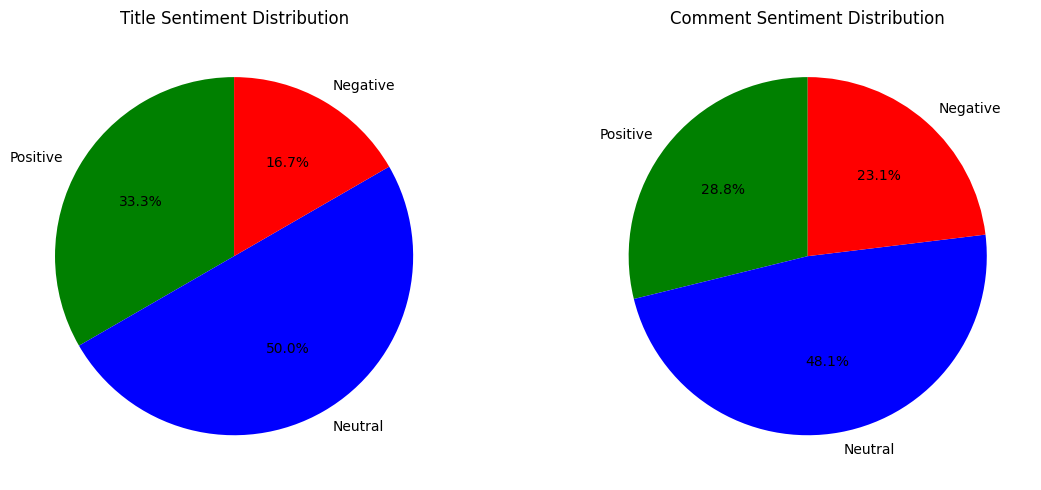

In [174]:
import matplotlib.pyplot as plt

def visualize_sentiment(title_sentiments, comment_sentiments):
    # Define sentiment labels
    labels = ["Positive", "Neutral", "Negative"]

    # Sample sentiment counts (replace with your actual data)
    title_sentiment_counts = [20, 30, 10]
    comment_sentiment_counts = [15, 25, 12]

    # Create subplots for titles and comments
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot sentiment distribution for titles
    axes[0].pie(title_sentiment_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'blue', 'red'])
    axes[0].set_title('Title Sentiment Distribution')

    # Plot sentiment distribution for comments
    axes[1].pie(comment_sentiment_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['green', 'blue', 'red'])
    axes[1].set_title('Comment Sentiment Distribution')

    # Display the pie charts
    plt.tight_layout()
    plt.show()

# Sample sentiment data (replace with your actual data)
title_sentiments = ["Positive", "Neutral", "Negative"]
comment_sentiments = ["Neutral", "Positive", "Negative"]

# Call the function to visualize sentiment
visualize_sentiment(title_sentiments, comment_sentiments)
